# State tomography
State tomography involves measuring a quantum state repeatedly in the bases given by `itertools.product(['X', 'Y', 'Z], repeat=n_qubits)`. From these measurements, we can reconstruct a density matrix $\rho$.

In [1]:
import numpy as np
from pyquil import Program, get_qc
from pyquil.gates import *

## Construct a state with a `Program`
We'll construct a two-qubit graph state by Hadamarding all qubits and then applying a controlled-Z operation across edges of our graph. In the two-qubit case, there's only one edge. 

In [2]:
qubits = [0, 1]
program = Program()
for qubit in qubits:
    program += H(qubit)
program += CZ(qubits[0], qubits[1])
print(program)

H 0
H 1
CZ 0 1



## Construct a `TomographyExperiment` for state tomography
We can print this out to see the 16 measurements we will perform.

In [3]:
from forest_benchmarking.tomography import generate_state_tomography_experiment
experiment = generate_state_tomography_experiment(program=program, qubits=qubits)
print(experiment)

H 0; H 1; CZ 0 1
0: (1+0j)*I→(1+0j)*I
1: (1+0j)*I→(1+0j)*X1
2: (1+0j)*I→(1+0j)*Y1
3: (1+0j)*I→(1+0j)*Z1
4: (1+0j)*I→(1+0j)*X0
5: (1+0j)*I→(1+0j)*X0X1
6: (1+0j)*I→(1+0j)*X0Y1
7: (1+0j)*I→(1+0j)*X0Z1
8: (1+0j)*I→(1+0j)*Y0
9: (1+0j)*I→(1+0j)*Y0X1
10: (1+0j)*I→(1+0j)*Y0Y1
11: (1+0j)*I→(1+0j)*Y0Z1
12: (1+0j)*I→(1+0j)*Z0
13: (1+0j)*I→(1+0j)*Z0X1
14: (1+0j)*I→(1+0j)*Z0Y1
15: (1+0j)*I→(1+0j)*Z0Z1


### Optional grouping
We can simultaneously estimate some of these observables

In [4]:
from pyquil.operator_estimation import group_experiments
print(group_experiments(experiment))

H 0; H 1; CZ 0 1
0: (1+0j)*I→(1+0j)*X1, (1+0j)*I→(1+0j)*X0X1, (1+0j)*I→(1+0j)*X0, (1+0j)*I→(1+0j)*I
1: (1+0j)*I→(1+0j)*Y0, (1+0j)*I→(1+0j)*Y0Y1, (1+0j)*I→(1+0j)*Y1
2: (1+0j)*I→(1+0j)*Z1, (1+0j)*I→(1+0j)*Z0, (1+0j)*I→(1+0j)*Z0Z1
3: (1+0j)*I→(1+0j)*X0Y1
4: (1+0j)*I→(1+0j)*X0Z1
5: (1+0j)*I→(1+0j)*Y0X1
6: (1+0j)*I→(1+0j)*Y0Z1
7: (1+0j)*I→(1+0j)*Z0X1
8: (1+0j)*I→(1+0j)*Z0Y1


## PyQuil will run the tomography programs

In [5]:
from pyquil.operator_estimation import measure_observables

qc = get_qc('2q-pyqvm')
# Over-write full quilc compilation with a much more simple
# version that *only* substitutes gates to Rigetti-native gates.
# We don't want to accidentally compile away our tomography circuit
# or map to different qubits.
from forest_benchmarking.compilation import basic_compile
qc.compiler.quil_to_native_quil = basic_compile

results = list(measure_observables(qc=qc, tomo_experiment=experiment, n_shots=100_000))
results

[ExperimentResult[(1+0j)*I→(1+0j)*I: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*X1: -0.00368 +- 0.003162256247681392],
 ExperimentResult[(1+0j)*I→(1+0j)*Y1: 0.00248 +- 0.003162267935517166],
 ExperimentResult[(1+0j)*I→(1+0j)*Z1: 0.00238 +- 0.003162268703952908],
 ExperimentResult[(1+0j)*I→(1+0j)*X0: -0.002 +- 0.003162271335606734],
 ExperimentResult[(1+0j)*I→(1+0j)*X0X1: 0.00044 +- 0.0031622773540598867],
 ExperimentResult[(1+0j)*I→(1+0j)*X0Y1: -0.00596 +- 0.00316222149508854],
 ExperimentResult[(1+0j)*I→(1+0j)*X0Z1: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0: 0.00698 +- 0.003162200625513821],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0X1: -0.0042 +- 0.0031622497687564142],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0Y1: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*Y0Z1: 0.00218 +- 0.0031622701459552757],
 ExperimentResult[(1+0j)*I→(1+0j)*Z0: -0.0013 +- 0.0031622749880426283],
 ExperimentResult[(1+0j)*I→(1+0j)*Z0X1: 1.0 +- 0.0],
 ExperimentResult[(1+0j)*I→(1+0j)*Z0Y1: -0.00664 +- 0.00316

### We can look at a bunch of numbers...

In [6]:
from forest_benchmarking.tomography import linear_inv_state_estimate
rho = linear_inv_state_estimate(results, qubits=qubits)
np.round(rho, 3)

array([[ 0.25 +0.j   ,  0.25 -0.002j,  0.249+0.001j, -0.25 +0.003j],
       [ 0.25 +0.002j,  0.251-0.j   ,  0.25 +0.j   , -0.251-0.002j],
       [ 0.249-0.001j,  0.25 -0.j   ,  0.249-0.j   , -0.251-0.001j],
       [-0.25 -0.003j, -0.251+0.002j, -0.251+0.001j,  0.25 -0.j   ]])

In [7]:
psi = (1/2) * np.array([1, 1, 1, -1])
rho_true = np.outer(psi, psi.T.conj())
rho_true

array([[ 0.25,  0.25,  0.25, -0.25],
       [ 0.25,  0.25,  0.25, -0.25],
       [ 0.25,  0.25,  0.25, -0.25],
       [-0.25, -0.25, -0.25,  0.25]])

### Or visualize using Hinton plots

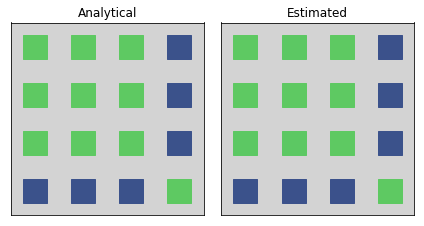

In [8]:
from matplotlib import pyplot as plt
from forest_benchmarking.plotting import hinton
fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_true, ax=ax1)
hinton(rho, ax=ax2)
ax1.set_title('Analytical')
ax2.set_title('Estimated')
fig.tight_layout()

### Matrix norm between true and estimated is low

In [9]:
np.linalg.norm(rho - rho_true)

0.006755412644687231

## Linear inversion estimate

[[ 0.2505+0.j      0.2495-0.0023j  0.2491+0.001j  -0.2499+0.0025j]
 [ 0.2495+0.0023j  0.2507-0.j      0.2501+0.0004j -0.2509-0.0023j]
 [ 0.2491-0.001j   0.2501-0.0004j  0.2489-0.j     -0.2505-0.0012j]
 [-0.2499-0.0025j -0.2509+0.0023j -0.2505+0.0012j  0.2499-0.j    ]]
Purity = (1.0000456356-2.3145005877134306e-16j)


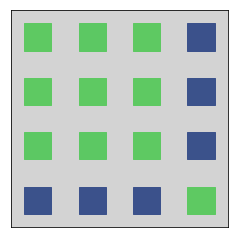

In [10]:
from forest_benchmarking.tomography import linear_inv_state_estimate
rho = linear_inv_state_estimate(results, qubits=qubits)

print(np.round(rho, 4))
print('Purity =', np.trace(rho @ rho))
hinton(rho)

## Maximum Liklihood Estimate (MLE) via diluted iterative method

[[ 0.2496+0.j      0.2496-0.0006j  0.25  -0.0015j -0.25  +0.0005j]
 [ 0.2496+0.0006j  0.2495-0.j      0.25  -0.0009j -0.25  -0.0001j]
 [ 0.25  +0.0015j  0.25  +0.0009j  0.2504-0.j     -0.2504-0.001j ]
 [-0.25  -0.0005j -0.25  +0.0001j -0.2504+0.001j   0.2504+0.j    ]]
Purity = (0.9999999950084171+1.4162390878091902e-18j)


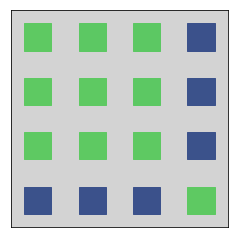

In [11]:
from forest_benchmarking.tomography import iterative_mle_state_estimate
est_mle, status = iterative_mle_state_estimate(results=results, qubits=qubits,
                                               dilution=0.5)
rho = est_mle.estimate.state_point_est
print(np.around(rho, decimals=4))
print('Purity =', np.trace(rho @ rho))
hinton(rho)

## MLE with Max Entropy constraint

[[ 0.2496-0.j      0.2496-0.0006j  0.25  -0.0015j -0.25  +0.0005j]
 [ 0.2496+0.0006j  0.2495+0.j      0.25  -0.0009j -0.25  -0.0001j]
 [ 0.25  +0.0015j  0.25  +0.0009j  0.2504+0.j     -0.2504-0.001j ]
 [-0.25  -0.0005j -0.25  +0.0001j -0.2504+0.001j   0.2504-0.j    ]]
Purity = (0.9999999950083889-1.1519648082658485e-19j)


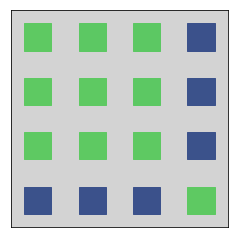

In [12]:
est_max_ent, stat = iterative_mle_state_estimate(results=results, qubits=qubits,
                                                 dilution=0.5, entropy_penalty=0.005)
rho = est_max_ent.estimate.state_point_est
print(np.around(rho, decimals=4))
print('Purity =', np.trace(rho @ rho))
hinton(rho)

## MLE with Hedging parameter

[[ 0.2496-0.j      0.2496-0.0006j  0.25  -0.0015j -0.25  +0.0005j]
 [ 0.2496+0.0006j  0.2495+0.j      0.25  -0.0009j -0.25  -0.0001j]
 [ 0.25  +0.0015j  0.25  +0.0009j  0.2504+0.j     -0.2504-0.001j ]
 [-0.25  -0.0005j -0.25  +0.0001j -0.2504+0.001j   0.2504-0.j    ]]
Purity =  (0.9999999949971228-4.1335207826009857e-19j)


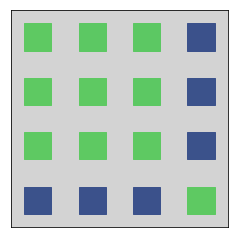

In [13]:
est_hedging, stat = iterative_mle_state_estimate(results=results, qubits=qubits,
                                                 dilution=0.5, beta=.61)
rho = est_hedging.estimate.state_point_est
print(np.around(rho, decimals=4))
print('Purity = ', np.trace(rho @ rho))
hinton(rho)

## Project an unphysical state to the closest physical state

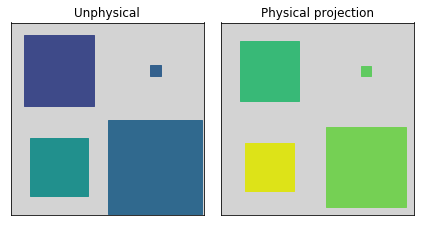

In [14]:
from forest_benchmarking.tomography import project_density_matrix
rho_unphys = np.random.uniform(-1, 1, (2, 2)) \
    * np.exp(1.j * np.random.uniform(-np.pi, np.pi, (2, 2)))
rho_phys = project_density_matrix(rho_unphys)

fig, (ax1, ax2) = plt.subplots(1, 2)
hinton(rho_unphys, ax=ax1)
hinton(rho_phys, ax=ax2)
ax1.set_title('Unphysical')
ax2.set_title('Physical projection')
fig.tight_layout()

In [15]:
# Test the wizard method. Example from fig 1 of maximum likelihood minimum effort 
# https://doi.org/10.1103/PhysRevLett.108.070502

eigs = np.diag(np.array(list(reversed([3.0/5, 1.0/2, 7.0/20, 1.0/10, -11.0/20]))))
phys = project_density_matrix(eigs)
np.allclose(phys, np.diag([0, 0, 1.0/5, 7.0/20, 9.0/20]))

True

# Lightweight Bootstrap for functionals of the state

In [16]:
import forest_benchmarking.distance_measures as dm
from forest_benchmarking.tomography import estimate_variance

In [17]:
def my_mle_estimator(_results, _qubits):
    return iterative_mle_state_estimate(_results, _qubits, dilution=0.5, entropy_penalty=0.0, beta=0.0)[0]

**Purity**

In [18]:
mle_est = estimate_variance(results, qubits, my_mle_estimator, dm.purity,
                            n_resamples=40, project_to_physical=True)
lin_inv_est = estimate_variance(results, qubits, linear_inv_state_estimate, dm.purity,
                                n_resamples=40, project_to_physical=True)
print(mle_est)
print(lin_inv_est)

(0.9999798196496783, 2.5831425682507553e-10)
(0.9959003341351187, 1.0789080803515433e-06)


**Fidelity**

In [19]:
mle_est = estimate_variance(results, qubits, my_mle_estimator, dm.fidelity,
                            target_state=rho_true, n_resamples=40, project_to_physical=True)
lin_inv_est = estimate_variance(results, qubits, linear_inv_state_estimate, dm.fidelity,
                                target_state=rho_true, n_resamples=40, project_to_physical=True)
print(mle_est)
print(lin_inv_est)

/home/kylegulshen/forest-benchmarking/forest_benchmarking/tomography.py:836: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if target_state == 'null':


Matrix is singular and may not have a square root.
Matrix is singular and may not have a square root.


ValueError: array must not contain infs or NaNs